2012- Robert M Dorazio & J. Andrew Royle. Estimating Size and Composition of Biological Communities by Modeling the occurrence of Species.
https://doi.org/10.1198/016214505000000015

Zero-inflated model

MacKenzie et al. 2006

MacKenzie et al. 2002

In [1]:
import shutil
import os
import zipfile
from joblib import dump, load
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch  # for legend patch
from scipy.optimize import minimize_scalar
from scipy.stats import norm, beta

In [2]:
# Remove the directory and all its contents
if os.path.exists('MinduPark'):
    shutil.rmtree('MinduPark')
    print("Folder 'MinduPark' removed.")
if os.path.exists('MinduPark_without_sauim'):
    shutil.rmtree('MinduPark_without_sauim')
    print("Folder 'MinduPark_without_sauim' removed.")

Auxiliar funtions

In [3]:
def w_mle_variance_ci(k, K, p11, alpha=0.05, eps=1e-12):
    """
    Estima w_hat, Var(w_hat), SE(w_hat) e ICs (Wald e Clopper-Pearson)
    no modelo q = w * p11, k ~ Bin(K, q).

    Parâmetros:
      k    : nº de sítios com ≥1 detecção
      K    : nº total de sítios
      p11  : prob. de detecção quando ocupado (fixa/conhecida)
      alpha: nível do IC (padrão 0.05 → 95%)
      eps  : evita divisão por zero e log(0) se você quiser recortar

    Retorna:
      dict com w_hat, var_wald, se_wald, ci_wald, ci_clopper_pearson
    """
    if not (0 <= k <= K):
        raise ValueError("Exige 0 <= k <= K.")
    if not (0 < p11 <= 1):
        raise ValueError("Exige 0 < p11 <= 1.")

    # MLE fechada
    q_hat = k / K
    w_hat = np.clip(q_hat / p11, 0.0, 1.0)

    # Variância (delta-método) e SE
    var_wald = (q_hat * (1 - q_hat)) / (K * (p11 ** 2))
    se_wald = float(np.sqrt(max(var_wald, 0.0)))

    # IC de Wald
    z = norm.ppf(1 - alpha / 2)
    ci_wald = (
        float(np.clip(w_hat - z * se_wald, 0.0, 1.0)),
        float(np.clip(w_hat + z * se_wald, 0.0, 1.0)),
    )

    # IC exato de Clopper–Pearson para q, depois transformar para w
    if k == 0:
        q_lo = 0.0
    else:
        q_lo = beta.ppf(alpha / 2, k, K - k + 1)

    if k == K:
        q_hi = 1.0
    else:
        q_hi = beta.ppf(1 - alpha / 2, k + 1, K - k)

    ci_cp = (
        float(np.clip(q_lo / p11, 0.0, 1.0)),
        float(np.clip(q_hi / p11, 0.0, 1.0)),
    )

    return {
        "w_hat": float(w_hat),
        "var_wald": float(var_wald),
        "se_wald": se_wald,
        "ci_wald": ci_wald,
        "ci_clopper_pearson": ci_cp,
    }

## Ocumpacy modeling

Automatically download the necessary files

In [4]:
!wget https://github.com/juancolonna/Sauim/raw/main/MinduPark.zip -O MinduPark.zip
!wget https://github.com/juancolonna/Sauim/raw/main/MinduPark_without_sauim.zip -O MinduPark_without_sauim.zip
!wget https://github.com/juancolonna/Sauim/raw/main/ocsvm.joblib -O ocsvm.joblib

--2025-08-29 01:38:45--  https://github.com/juancolonna/Sauim/raw/main/MinduPark.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/juancolonna/Sauim/main/MinduPark.zip [following]
--2025-08-29 01:38:45--  https://media.githubusercontent.com/media/juancolonna/Sauim/main/MinduPark.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42146012 (40M) [application/zip]
Saving to: ‘MinduPark.zip’

MinduPark.zip       100%[===================>]  40.19M  58.5MB/s    in 0.7s    

2025-08-29 01:38:46 (58.5 MB/s) - ‘MinduPark.zip’ saved [42146012/42146012]

--2025-08-29 01:38:46--  https://

In [5]:
# Open and extract files
with zipfile.ZipFile('MinduPark.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

with zipfile.ZipFile('MinduPark_without_sauim.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

print(f'Files extracted')

Files extracted


In [6]:
clf = load("ocsvm.joblib")

In [7]:
cm = np.array([[179,0],[4,32]])

# Fixed parameters
p10 = cm[0,1]/cm.sum(axis=1)[0]  # prob. of "false detection"
p11 = cm[1,1]/cm.sum(axis=1)[1]  # prob. of "detection"
p01 = 1-p11
p00 = 1-p10

eps = 1e-10

print(f"p11:{p11}, p10:{p10}, p01:{p01}, p00:{p00}")

p11:0.8888888888888888, p10:0.0, p01:0.11111111111111116, p00:1.0


Semples monitoring with Sauim occurrences

In [8]:
y = []
T = []
detections_per_record = []

for i in range(8):
    MinduPark_embedding_vectors = np.load("MinduPark/MinduPark_vectors_filtered_"+str(i)+".npy")
    decision_scores = clf.decision_function(MinduPark_embedding_vectors)
    MinduPark_preds = np.where(decision_scores >= 0, 1, 0)
    y.append(np.sum(MinduPark_preds == 1))
    T.append(len(MinduPark_preds))
    detections_per_record.append(MinduPark_preds)

y = np.array(y)
T = np.array(T)
print(y) # How many detections per record
print(T) # How many segments per record

[ 51   0   0  10 261  55  54 112]
[ 757  149  109  309 1036  360  419 1320]


In [9]:
detections = int(np.sum(y > 0))
detections

6

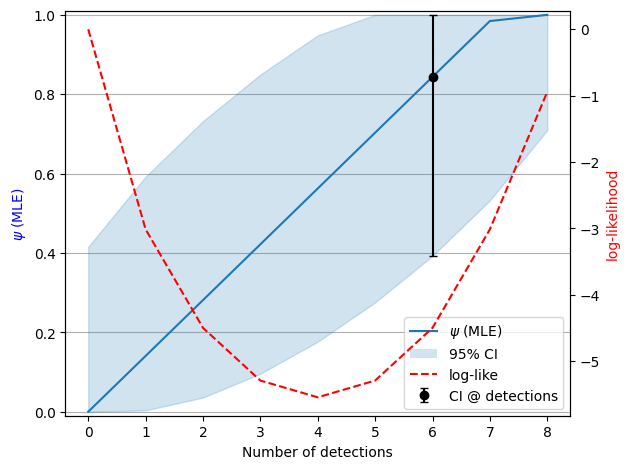

In [15]:
K = len(y)
mle_w = []
logLike = []
w_lo = []   # CP lower bounds for w
w_hi = []   # CP upper bounds for w

for k in range(len(y)+1):
    def loglike(w):
        if w <= 0 or w >= 1:
            return -np.inf  # fora do domínio
        q = w * p11
        q = np.clip(q, eps, 1 - eps)
        return k*np.log(q) + (K - k)*np.log(1 - q)


    res = minimize_scalar(lambda w: -loglike(w), bounds=(0,1), method="bounded")
    mle_w.append(res.x)
    logLike.append(-res.fun)

    # Clopper–Pearson for this k, transform to w via divide by p11 (inside helper)
    ci_res = w_mle_variance_ci(k, K, p11, alpha=0.05)
    lo, hi = ci_res["ci_clopper_pearson"]
    w_lo.append(lo)
    w_hi.append(hi)

detections = int(np.sum(y > 0))

# --- plotting ---
fig, ax1 = plt.subplots()

x = np.arange(len(mle_w))  # x = 0..K

# left y-axis: w
l1, = ax1.plot(x, mle_w, label="$\\psi$ (MLE)")  # psi = occupancy prob = w
ax1.set_ylabel("$\\psi$ (MLE)", color="blue")
ax1.set_ylim(-0.01, 1.01)

# shaded CP band
band = ax1.fill_between(x, w_lo, w_hi, alpha=0.2, color=l1.get_color())
ci_patch = Patch(facecolor=l1.get_color(), alpha=0.2, label="95% CI")

# mark the actual detections with error bar
y_hat_at_det = mle_w[detections]
lo_at_det = w_lo[detections]
hi_at_det = w_hi[detections]
yerr_det = np.array([[y_hat_at_det - lo_at_det], [hi_at_det - y_hat_at_det]])
eb = ax1.errorbar([detections], [y_hat_at_det], yerr=yerr_det, fmt='o', color='black',
                  capsize=3, label="CI @ detections")

# right y-axis: log-likelihood
ax2 = ax1.twinx()
l2, = ax2.plot(x, logLike, label="log-like", color="red", linestyle="--")
ax2.set_ylabel("log-likelihood", color="red")

ax1.set_xlabel("Number of detections")
# ax1.set_title("MLE $\\psi$ vs. log-likelihood with 95% CI")

# combined legend
lines = [l1, ci_patch, l2, eb]
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="lower right")

fig.tight_layout()

ax1.grid(True, axis='y', which='both')
ax2.grid(False)
ax2.patch.set_visible(False)
ax1.set_axisbelow(True)

plt.savefig("likelihood.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Dados agregados:
k = int(np.sum(y > 0))   # nº de sítios com ≥1 detecção
K = int(len(y))          # nº total de sítios
eps = 1e-12              # p/ evitar log(0)

def loglike(w):
    if w <= 0 or w >= 1:
        return -np.inf  # fora do domínio
    q = w * p11
    q = np.clip(q, eps, 1 - eps)
    return k*np.log(q) + (K - k)*np.log(1 - q)

# Minimiza o negativo do log-likelihood
res = minimize_scalar(lambda w: -loglike(w), bounds=(eps, 1 - eps), method="bounded")

print("MLE estimate of w:", res.x)
print("Max log-likelihood:", -res.fun)


MLE estimate of w: 0.8437509741811843
Max log-likelihood: -4.498681156966463


In [13]:
# --- Exemplo de uso ---
# Suponha que você já tenha:
k = int(np.sum(y > 0))
K = int(len(y))

res = w_mle_variance_ci(k, K, p11, alpha=0.05)
print("ŵ:", res["w_hat"])
print("Var (Wald):", res["var_wald"])
print("SE (Wald):", res["se_wald"])
print("IC 95% (Wald):", res["ci_wald"])
print("IC 95% (Clopper–Pearson):", res["ci_clopper_pearson"])


ŵ: 0.84375
Var (Wald): 0.0296630859375
SE (Wald): 0.1722297475394422
IC 95% (Wald): (0.5061858977562672, 1.0)
IC 95% (Clopper–Pearson): (0.3927872312855728, 1.0)


Samples of monitoring without sauim occurrences

In [ ]:
y = []
T = []
detections_per_record = []

for i in range(8):
    MinduPark_embedding_vectors = np.load("MinduPark_without_sauim/MinduPark_vectors_filtered_"+str(i)+".npy")
    decision_scores = clf.decision_function(MinduPark_embedding_vectors)
    MinduPark_preds = np.where(decision_scores >= 0, 1, 0)
    y.append(np.sum(MinduPark_preds == 1))
    T.append(len(MinduPark_preds))
    detections_per_record.append(MinduPark_preds)

y = np.array(y)
T = np.array(T)
print(y) # How many detections per record
print(T) # How many segments per record

In [ ]:
# --- Exemplo de uso ---
# Suponha que você já tenha:
k = int(np.sum(y > 0))
K = int(len(y))

res = w_mle_variance_ci(k, K, p11, alpha=0.05)
print("ŵ:", res["w_hat"])
print("Var (Wald):", res["var_wald"])
print("SE (Wald):", res["se_wald"])
print("IC 95% (Wald):", res["ci_wald"])
print("IC 95% (Clopper–Pearson):", res["ci_clopper_pearson"])

Exemplo com mais de um sitio

In [ ]:
# # Supõe-se que você já tem:
# # y: lista/array com contagens por sítio
# # T: lista/array com nº de visitas por sítio
# # p11: prob. de detecção por visita (fixa)
# eps = 1e-12

# # Suas quantidades:
# k = int(np.sum(y > 0))                 # nº de sítios com ≥1 detecção
# K = int(len(y))                        # nº total de sítios
# d = (np.asarray(y) > 0).astype(int)    # indicador por sítio (0/1)
# T = np.asarray(T, int)                 # nº de visitas por sítio (mesmo tamanho de y)

# # Probabilidade de ≥1 detecção dado ocupado, por sítio
# pstar = 1.0 - np.power(1.0 - p11, T)

# def loglike(w):
#     if w <= 0 or w >= 1:
#         return -np.inf  # fora do domínio
#     # q_i = w * pstar_i
#     q = np.clip(w * pstar, eps, 1.0 - eps)
#     return float(np.sum(d * np.log(q) + (1 - d) * np.log(1.0 - q)))

# # Minimiza o negativo do log-likelihood
# res = minimize_scalar(lambda w: -loglike(w),
#                       bounds=(eps, 1.0 - eps),
#                       method="bounded")

# print("MLE estimate of w:", res.x)
# print("Max log-likelihood:", -res.fun)


In [ ]:
# from scipy.optimize import minimize_scalar

# k = np.sum(y>0)
# K = len(y)

# def loglike(w):
#     if w <= 0 or w >= 1:
#         return -np.inf  # outside domain
#     a = np.exp(k*np.log(p11) + (K-k)*np.log(1 - p11))
#     b = np.exp(k*np.log(p10) + (K-k)*np.log(1 - p10))
#     terms = w*a + (1-w)*b
#     terms = np.clip(terms, eps, 1-eps)
#     return np.sum(np.log(terms))

# # We minimize the negative log-likelihood
# res = minimize_scalar(lambda w: -loglike(w), bounds=(0,1), method="bounded")

# print("MLE estimate of w:", res.x)
# print("Max log-likelihood:", -res.fun)